<a href="https://colab.research.google.com/github/data-in-galaxy/Finetuning-LLM/blob/main/finetuning_llms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is finetuning?

Customizes a foundation model to a specific use cases



# Tasks to finetune

- Extraction: text in, less text out
  + "Reading"
  + Keywords, topics, etc.

- Expansion: text in, more text out
  + "Writing"
  + Chat, write emails, write code


# First-time finetuning

1. Identify tasks by prompt engineering a large LLM

2. Find tasks that you see an LLM doing OK at

3. Pick one task

4. Get ~1000 ideal pairs of inputs & outputs for the task

5. Finetune a small LLM on this data

In [ ]:
!pip install jsonlines
import jsonlines
import itertools
import pandas as pd
from pprint import pprint

!pip install datasets
import datasets
from datasets import load_dataset

In [2]:
# Load in "Common Crawl" dataset - can be used to train base model
pretrained_dataset = load_dataset("c4", "en", split="train", streaming=True)

In [3]:
n = 5
print("Pretrained dataset:")
top_n = itertools.islice(pretrained_dataset, n)
for i in top_n:
  print(i)

Pretrained dataset:
{'text': 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.', 'timestamp': '2019-04-25T12:57:54Z', 'url': 'https://klyq.com/beginners-bbq-class-taking-place-in-missoula/'}
{'text': 'Discussion in \'Mac OS X Lion (10.7)\' started by axboi87, Jan 20, 2012.\nI\'ve got a 500gb inter

## Upload company finetuned dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving lamini_docs.jsonl to lamini_docs.jsonl


In [7]:
filename = "lamini_docs.jsonl"

instruction_dataset_df = pd.read_json(filename, lines=True)
instruction_dataset_df

,question,answer
0,What are the different types of documents avai...,"Lamini has documentation on Getting Started, A..."
1,What is the recommended way to set up and conf...,Lamini can be downloaded as a python package a...
2,How can I find the specific documentation I ne...,"You can ask this model about documentation, wh..."
3,Does the documentation include explanations of...,Our documentation provides both real-world and...
4,Does the documentation provide information abo...,External dependencies and libraries are all av...
...,...,...
1395,What is Lamini and what is its collaboration w...,Lamini is a library that simplifies the proces...
1396,How does Lamini simplify the process of access...,Lamini simplifies data access in Databricks by...
1397,What are some of the key features provided by ...,Lamini automatically manages the infrastructur...
1398,How does Lamini ensure data privacy during the...,"During the training process, Lamini ensures da..."


## Format finetuning data

Concatenate "question"-"answer" pairs

In [8]:
examples = instruction_dataset_df.to_dict()
text = examples["question"][0] + examples["answer"][0]
text

"What are the different types of documents available in the repository (e.g., installation guide, API documentation, developer's guide)?Lamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https://lamini-ai.github.io/."

In [ ]:
# Multiple ways to concatenate the data pairs
'''
if "question" in examples and "answer" in examples:
  text = examples["question"][0] + examples["answer"][0]
elif "instruction" in examples and "response" in examples:
  text = examples["instruction"][0] + examples["response"][0]
elif "input" in examples and "output" in examples:
  text = examples["input"][0] + examples["output"][0]
else:
  text = examples["text"][0]
'''

In [9]:
# Create Question-Answer prompt to format data
prompt_template_qa = """### Question:
{question}

### Answer:
{answer}"""

In [10]:
question = examples["question"][0]
answer = examples["answer"][0]

text_with_prompt_template = prompt_template_qa.format(question=question, answer=answer)
text_with_prompt_template

"### Question:\nWhat are the different types of documents available in the repository (e.g., installation guide, API documentation, developer's guide)?\n\n### Answer:\nLamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https://lamini-ai.github.io/."

In [11]:
# Format only the question part
prompt_template_q = """### Question:
{question}

### Answer:"""

In [13]:
# Combine it all together
num_examples = len(examples["question"])
finetuning_dataset_text_only = []
finetuning_dataset_question_answer = []
for i in range(num_examples):
  question = examples["question"][i]
  answer = examples["answer"][i]

  text_with_prompt_template_qa = prompt_template_qa.format(question=question, answer=answer)
  finetuning_dataset_text_only.append({"text": text_with_prompt_template_qa})

  text_with_prompt_template_q = prompt_template_q.format(question=question)
  finetuning_dataset_question_answer.append({"question": text_with_prompt_template_q, "answer": answer})

In [14]:
pprint(finetuning_dataset_text_only[0])

{'text': '### Question:\n'
         'What are the different types of documents available in the '
         "repository (e.g., installation guide, API documentation, developer's "
         'guide)?\n'
         '\n'
         '### Answer:\n'
         'Lamini has documentation on Getting Started, Authentication, '
         'Question Answer Model, Python Library, Batching, Error Handling, '
         'Advanced topics, and class documentation on LLM Engine available at '
         'https://lamini-ai.github.io/.'}


In [15]:
pprint(finetuning_dataset_question_answer[0]) # more structured

{'answer': 'Lamini has documentation on Getting Started, Authentication, '
           'Question Answer Model, Python Library, Batching, Error Handling, '
           'Advanced topics, and class documentation on LLM Engine available '
           'at https://lamini-ai.github.io/.',
 'question': '### Question:\n'
             'What are the different types of documents available in the '
             'repository (e.g., installation guide, API documentation, '
             "developer's guide)?\n"
             '\n'
             '### Answer:'}


## Ways to store finetuning data

Can upload to Hugging Face

In [16]:
with jsonlines.open(f'lamini_docs_processed.jsonl', 'w') as writer:
    writer.write_all(finetuning_dataset_question_answer)

In [17]:
# Code below is for download the uploaded dataset from HuggingFace
finetuning_dataset_name = "lamini/lamini_docs"
finetuning_dataset = load_dataset(finetuning_dataset_name)
print(finetuning_dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/140 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})


## Instruction Tuning

A type of finetuning - teaches LLM to behave like chatbot

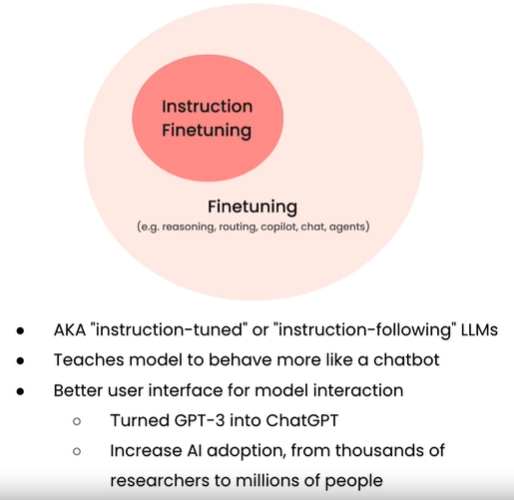

**Dataset**
Typically Q&A dataset:

- FAQs
- Customer support conversations
- Slack messages

### Workflow

1. Data Prep
- Vary by different tasks of finetuning<br>
<br>
2. Training
- Similar across tasks<br>
<br>
3. Evaluation
- Similar across tasks

In [ ]:
import itertools
!pip install jsonlines
import jsonlines

!pip install datasets
from datasets import load_dataset
from pprint import pprint

!pip install transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

#### Load instruction tuned dataset

In [3]:
instruction_tuned_dataset = load_dataset("tatsu-lab/alpaca", split="train", streaming=True)

In [4]:
m = 5
print("Instruction-tuned dataset:")
top_m = list(itertools.islice(instruction_tuned_dataset, m))
for j in top_m:
  print(j)

Instruction-tuned dataset:
{'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.', 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGive three tips for staying healthy.\n\n### Response:\n1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}
{'instruction': 'What are the three primary colors?', 'input': '', 'output': 'The three primary colors are red, blue, and yellow.', 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat are the three p

#### Two prompt templates

In [5]:
prompt_template_with_input = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}

### Response:"""

prompt_template_without_input = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Response:"""

#### Add data to prompts

In [6]:
processed_data = []
for j in top_m:
  if not j["input"]:
    processed_prompt = prompt_template_without_input.format(instruction=j["instruction"])
  else:
    processed_prompt = prompt_template_with_input.format(instruction=j["instruction"], input=j["input"])

  processed_data.append({"input": processed_prompt, "output": j["output"]})

In [7]:
pprint(processed_data[0])

{'input': 'Below is an instruction that describes a task. Write a response '
          'that appropriately completes the request.\n'
          '\n'
          '### Instruction:\n'
          'Give three tips for staying healthy.\n'
          '\n'
          '### Response:',
 'output': '1.Eat a balanced diet and make sure to include plenty of fruits '
           'and vegetables. \n'
           '2. Exercise regularly to keep your body active and strong. \n'
           '3. Get enough sleep and maintain a consistent sleep schedule.'}


#### Save data to jsonl

In [8]:
with jsonlines.open(f'alpaca_processed.jsonl', 'w') as writer:
    writer.write_all(processed_data)

In [ ]:
# alpaca dataset uploaded on huggingface
'''
dataset_path_hf = "lamini/alpaca"
dataset_hf = load_dataset(dataset_path_hf)
print(dataset_hf)
'''

### Compare non-instruction-tuned vs instruction-tuned models

In [9]:
from transformers import pipeline

In [ ]:
'''
non_instruct_model = pipeline(model="meta-llama/Llama-2-7b-hf")
non_instruct_output = non_instruct_model("Tell me how to train my dog to sit")
print("Not instruction-tuned output (Llama 2 Base):", non_instruct_output)
'''

In [ ]:
'''
instruct_model = pipeline(model="meta-llama/Llama-2-7b-chat-hf")
instruct_output = instruct_model("Tell me how to train my dog to sit")
print("Instruction-tuned output (Llama 2): ", instruct_output)
'''

### Load smaller models

In [12]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")

(…)a-70m/resolve/main/tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

(…)I/pythia-70m/resolve/main/tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

(…)70m/resolve/main/special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

(…)erAI/pythia-70m/resolve/main/config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

In [13]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )

  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

In [14]:
finetuning_dataset_path = "lamini/lamini_docs"
finetuning_dataset = load_dataset(finetuning_dataset_path)
print(finetuning_dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/140 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})


In [15]:
test_sample = finetuning_dataset["test"][0]
print(test_sample)

print(inference(test_sample["question"], model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


{'question': 'Can Lamini generate technical documentation or user manuals for software projects?', 'answer': 'Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.', 'input_ids': [5804, 418, 4988, 74, 6635, 7681, 10097, 390, 2608, 11595, 84, 323, 3694, 6493, 32, 4374, 13, 418, 4988, 74, 476, 6635, 7681, 10097, 285, 2608, 11595, 84, 323, 3694, 6493, 15, 733, 4648, 3626, 3448, 5978, 5609, 281, 2794, 2590, 285, 44003, 10097, 326, 310, 3477, 281, 2096, 323, 1097, 7681, 285, 1327, 14, 48746, 4212, 15, 831, 476, 5321, 12259, 247, 1534, 2408, 273, 673, 285, 3434, 275, 6153, 10097, 13, 6941, 731, 281, 2770, 327, 643, 7794, 273, 616, 6493, 15], 'attention

### Compare to finetuned small model

In [16]:
instruction_model = AutoModelForCausalLM.from_pretrained("lamini/lamini_docs_finetuned")

(…)_docs_finetuned/resolve/main/config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/282M [00:00<?, ?B/s]

(…)uned/resolve/main/generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [17]:
print(inference(test_sample["question"], instruction_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Yes, Lamini can generate technical documentation or user manuals for software projects. This can be achieved by providing a prompt for a specific technical question or question to the LLM Engine, or by providing a prompt for a specific technical question or question. Additionally, Lamini can be trained on specific technical questions or questions to help users understand the process and provide feedback to the LLM Engine. Additionally, Lamini


In [ ]:
# Upload instruction tuned dataset to Huggingface

# !pip install huggingface_hub
# !huggingface-cli login

# import pandas as pd
# import datasets
# from datasets import Dataset

# finetuning_dataset = Dataset.from_pandas(pd.DataFrame(data=finetuning_dataset))
# finetuning_dataset.push_to_hub(dataset_path_hf)

### Instruction Tuning: Data Preparation

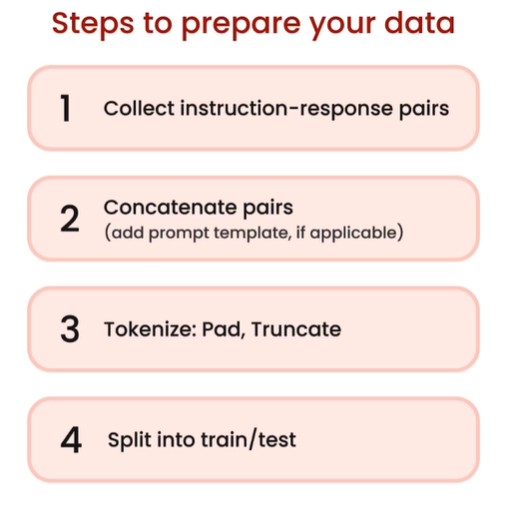

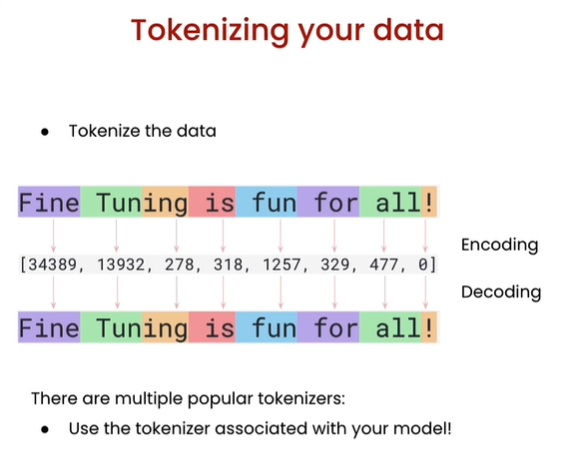


In [18]:
import pandas as pd
import datasets

from pprint import pprint
from transformers import AutoTokenizer